# A - Setup

#### Import libs

In [159]:
import warnings
warnings.filterwarnings("ignore")

In [160]:
import numpy as np, pandas as pd
import math

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For model building
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#### Common methods for displaying and model building

In [161]:
# Setup default environment for display data and charts
def setup_env(seaborn_style = 'ticks', context='paper', max_columns = 200, max_rows=200):
    sns.set_style(seaborn_style)
    sns.set_context(context)
    #sns.set_palette(Cplan.get_palete("blues"))
    pd.set_option("display.max_columns", max_columns, "display.max_rows", max_rows,"display.max_colwidth", 200)
    return

In [162]:
# For visualisation
def vs_data(data, cols, var_type = 'numerical', target = None, fig_size = (15,10), ncols = 3):
    #ncols=3
    plt.figure(figsize=fig_size)
    i=0
    if var_type in ['numerical', 'n']:
        if target == None:
            n_subs = (len(cols)*(len(cols)-1)//2)
            nrows = math.ceil(n_subs/ncols)
            for x in range(len(cols)):
                for y in range(len(cols)):
                    if y > x:
                        i+=1
                        plt.subplot(nrows, ncols, i)
                        sns.scatterplot(data, x= cols[x], y=cols[y])
        else:
            nrows = math.ceil(len(cols)/ncols)
            for x in cols:
                i+=1
                plt.subplot(nrows, ncols, i)
                sns.scatterplot(data, x= x, y=target)
    elif var_type in ['categorical', 'c']:
        nrows = math.ceil(len(cols)/ncols)
        for x in cols:
            i+=1
            plt.subplot(nrows, ncols, i)
            sns.boxplot(data, x= x, y=target)
    plt.show()
    return

#### Create Dummy Variables

In [163]:
# Create dummies
def create_dummies(data, col, prefix = None, drop = True):
    dummies = pd.get_dummies(data[col],prefix=prefix ,drop_first=drop)  
    df = pd.concat([data, dummies], axis=1)
    return df


#### Build a linear model

In [164]:
def build_lm(X_train, y_train):
    # Add a constant
    X_train_lm = sm.add_constant(X_train)

    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()

    # Print a summary of the linear regression model obtained
    # print(lr.summary())
    return lr

#### Calculating VIF

In [165]:
# Create function to calculate VIFs
def vif_calculation(data):
    vif = pd.DataFrame()
    vif['Features'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

#### Setup environment

In [166]:
setup_env()

# B - Bike-sharing Case Study

 **Need to do following steps:**

    1- Reading and Understanding the Data
    2- Visualizing the Data
    3- Data Preparation (mapping, treating categorical variables)
        + Splitting the Data into Training and Test Sets
        + Scaling 
        + Deviding into X and Y sets for model building
    4- Build Model
    5- Residual Analysis
    6- Making Predictions
    7- Model Evaluation
    8- Final Model Interpretation

### 1. Reading and Understanding the Data

In [167]:
bike_sharing = pd.read_csv('day.csv')

In [168]:
#check data
bike_sharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [169]:
# Checking size of data
bike_sharing.shape

(730, 16)

In [170]:
bike_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [171]:
bike_sharing.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [172]:
bike_sharing.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [173]:
bike_sharing.duplicated().value_counts()

False    730
dtype: int64

**Insights:**
* The Dataset does not containt missing values
* The Dataset does not containt duplicated values 
* The data of each column is in reasonable range
* Binary categorical variables: yr, holiday, working day
* Other categorical variables: season, mnth, week day, weathersit
* Nummerical variables: temp, atemp, hum, windspeed, casual, registered, cnt 

### 2. Visualising the Data

In [174]:
# Change the name of columns for clearer meaning
bike_sharing_new = bike_sharing.rename({'yr':'year', 'mnth':'month'}, axis=1)

# Convert 'season', 'weathersit', 'month', 'weekday' into categorical string values for better analysing.
bike_sharing_new['season'] = bike_sharing_new['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bike_sharing_new['weathersit'] = bike_sharing_new['weathersit'].map({1:'Clear', 2:'Misty', 
                                                             3:'Light_snow_rain', 4:'Heavy_snow_rain'})
bike_sharing_new['month'] = bike_sharing_new['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: 'May', 6:'Jun', 
                                                7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
bike_sharing_new['weekday'] = bike_sharing_new['weekday'].map({0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5: 
                                                               'Fri', 6:'Sat'})

In [175]:
bike_sharing_new.head()

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,Jan,0,Mon,1,Misty,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,Jan,0,Tue,1,Misty,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Visualising Numerical Variables

In [181]:
# Numerical variables
# 'casual' and 'registered' are excluded because they only help to construct target variable 'cnt'
n_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

<Figure size 1500x1000 with 0 Axes>

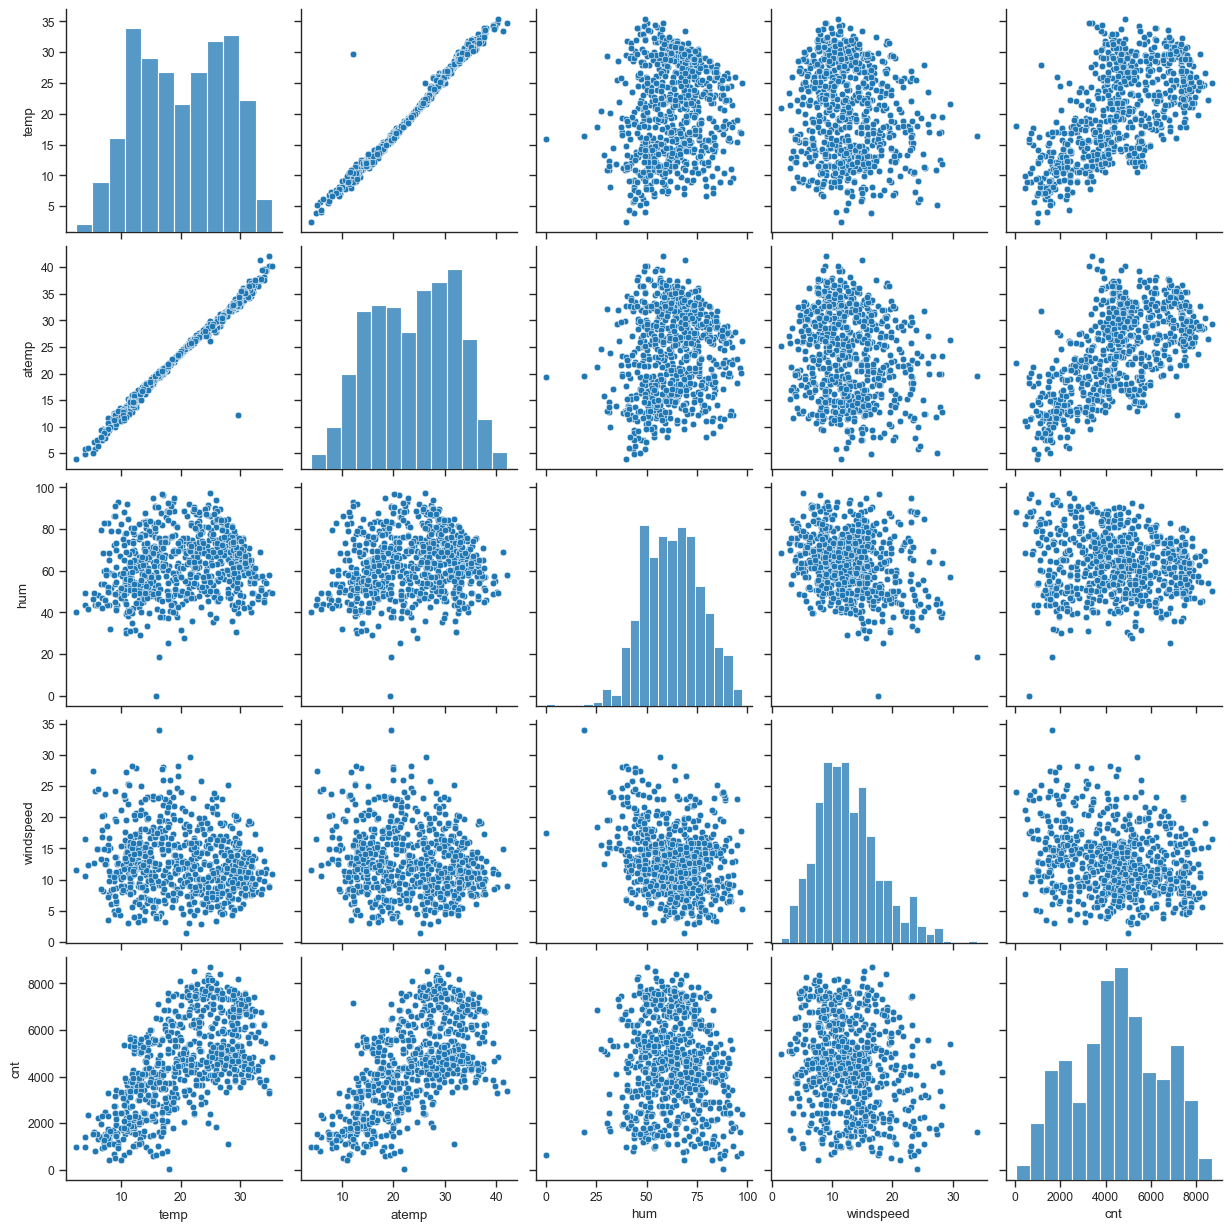

In [182]:
# Visualising Numeric Variables

plt.figure(figsize=(15,10))
sns.pairplot(bike_sharing_new[n_vars])
plt.show()

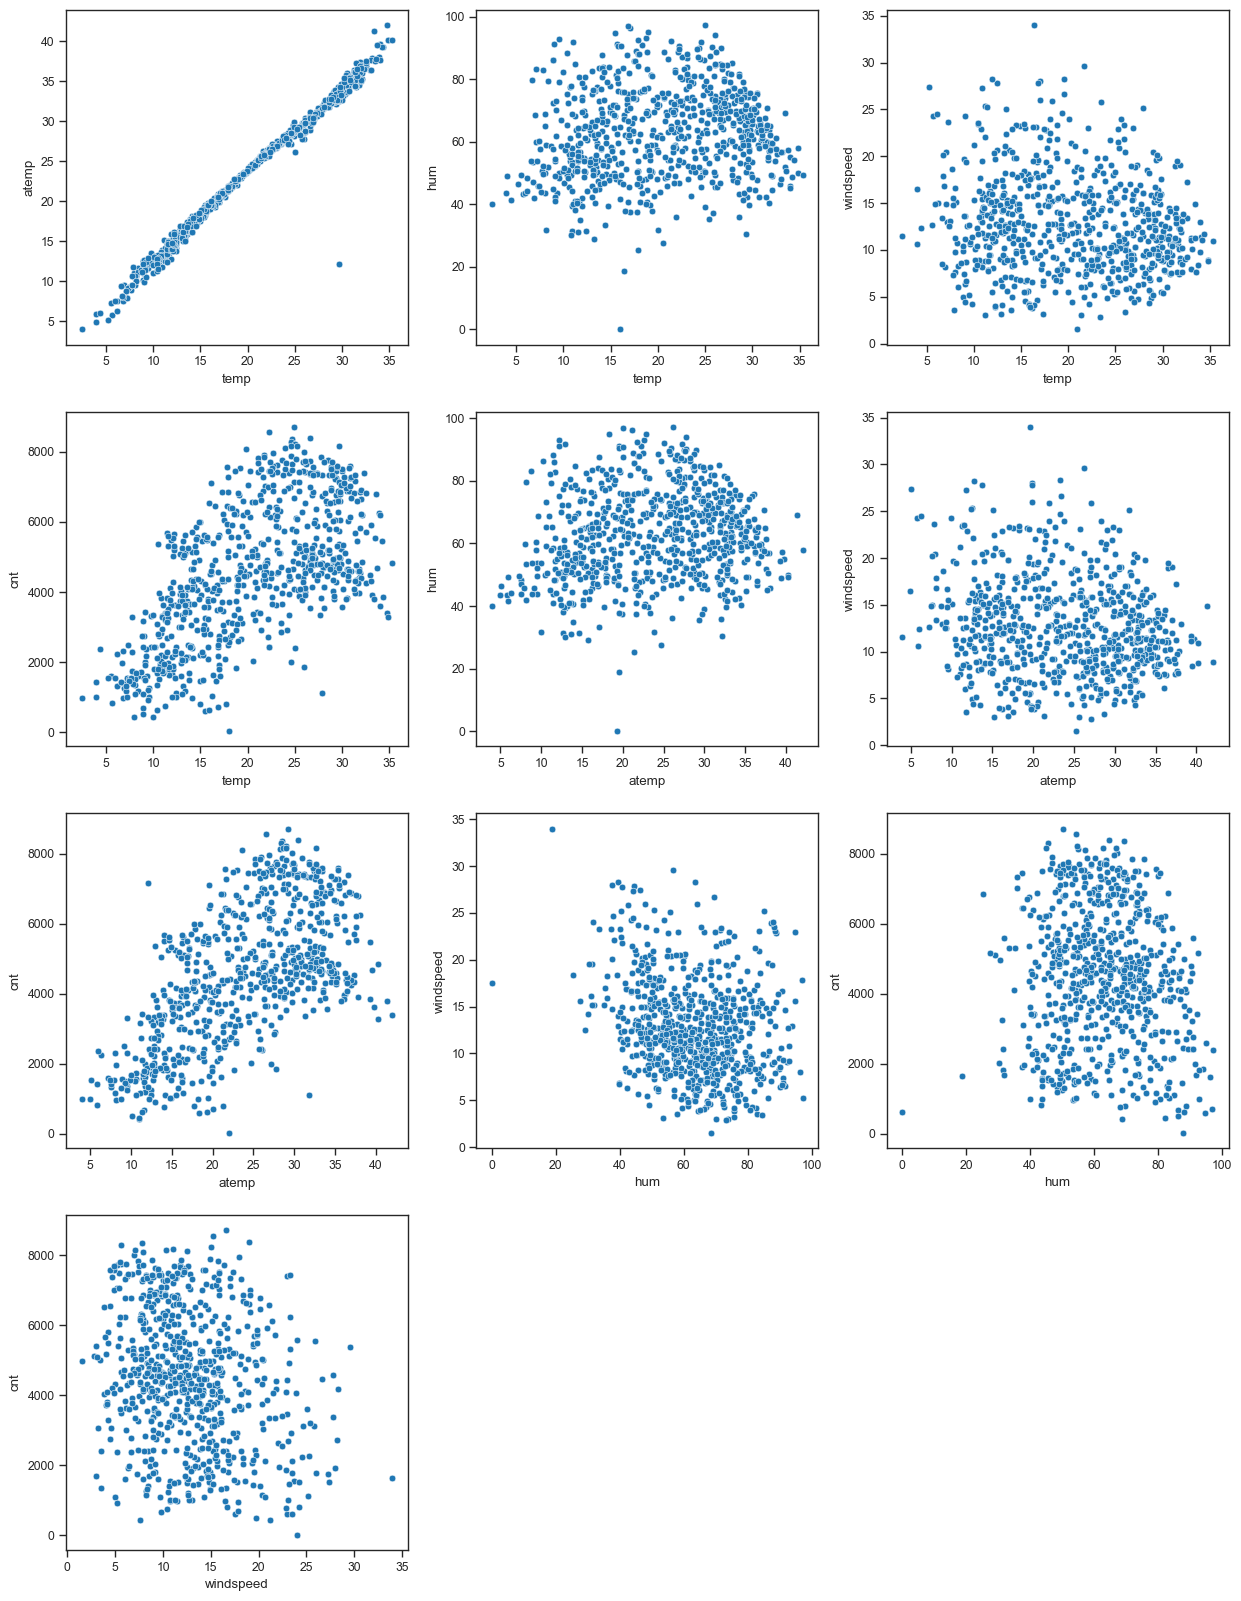

In [184]:
# For better view
vs_data(bike_sharing_new, cols = n_vars, var_type='n', fig_size=(15,20))

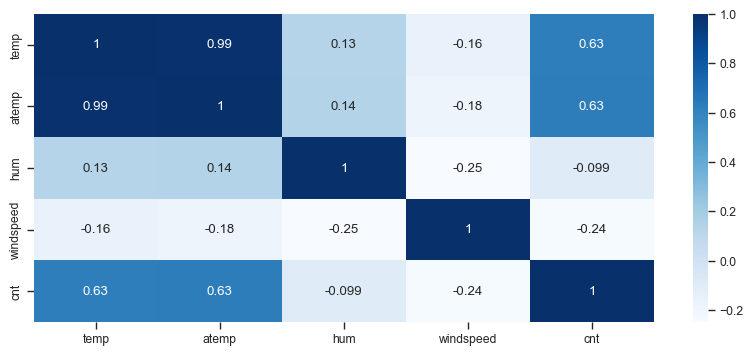

In [185]:
plt.figure(figsize=(10,4))
sns.heatmap(bike_sharing_new[n_vars].corr(), annot=True, cmap='Blues')
plt.show()

**Insights:**
* There are linear correlations between dependent and independent variables: temp/atemp and cnt

#### Visualising Categorical Variables

In [186]:
c_vars = ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weathersit']

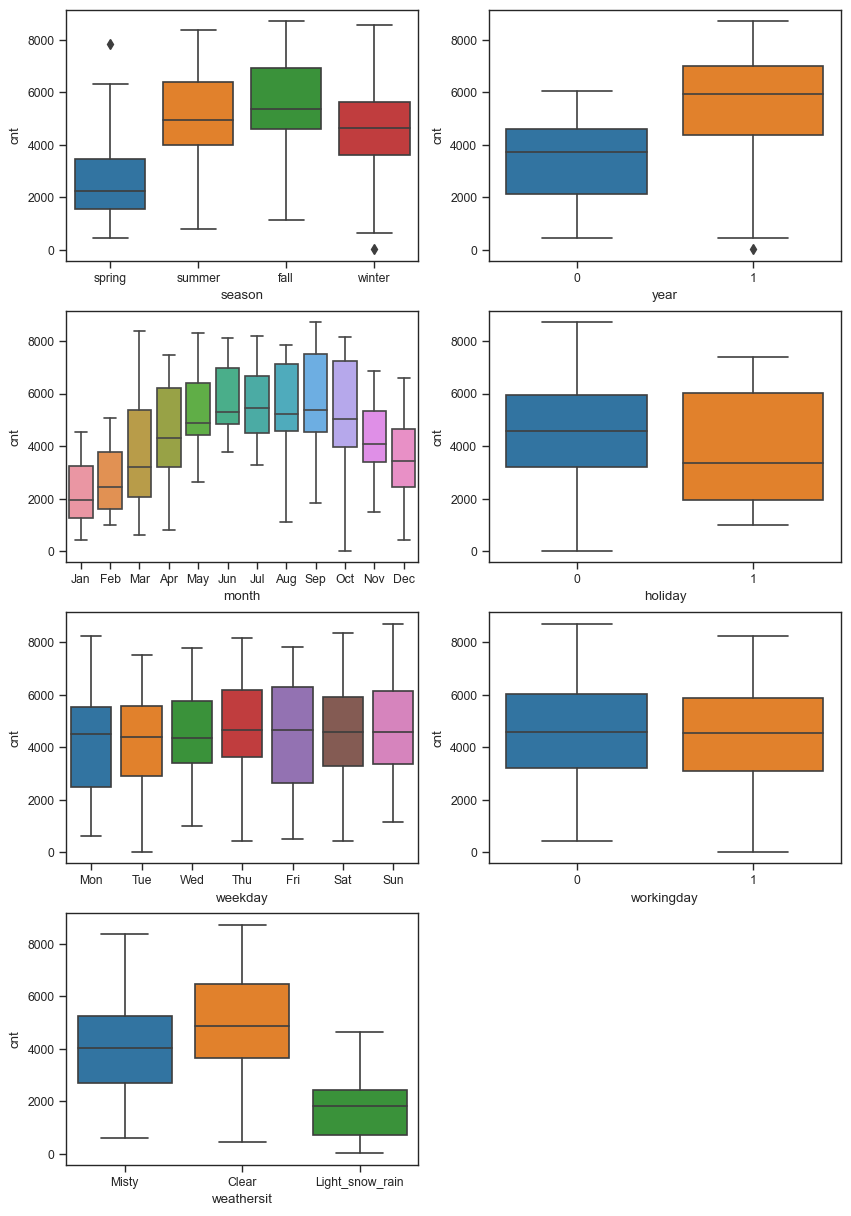

In [187]:
vs_data(bike_sharing_new, cols=c_vars, var_type='c', target='cnt', fig_size=(10,15), ncols=2)

**Insights:**
* The number of retal bikes is higher in fall and summer, lower in spring and fall
* The number of retal bikes is higher in 2019
* Most number of retal bikes placed in month 6,7,8,9
* In holiday, the number of retal bikes is lower than in non_holiday
* Median of retal bikes are about the same in different types of workingday and weekday
* The number of retal bikes is higher in nice/clear weather (Clear, Few clouds, Partly cloudy, Partly cloudy)

### 3. Data Preparation

#### Create dummy variables

In [188]:
# Categorical Variables needed to create dummies: 'season', 'mnth', 'weekday', 'weathersit'
# season:
bike_sharing_new = create_dummies(bike_sharing_new, 'season')

# mnth
bike_sharing_new = create_dummies(bike_sharing_new, 'month')

# mnth
bike_sharing_new = create_dummies(bike_sharing_new, 'weekday')

# mnth
bike_sharing_new = create_dummies(bike_sharing_new, 'weathersit')

In [189]:
bike_sharing_new.head()

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snow_rain,Misty
0,1,01-01-2018,spring,0,Jan,0,Mon,1,Misty,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2,02-01-2018,spring,0,Jan,0,Tue,1,Misty,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,3,03-01-2018,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,04-01-2018,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5,05-01-2018,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Drop unused columns:
* **instant** : It's just an index value
* **dteday** : This is the date. We will use year, month, weekday variables instead.
* **casual & registered**: contains the count of bike booked by different categories of customers. We will use **cnt** as dependent variable.
* Categorical variables: **'season', 'month', 'weekday', 'weathersit'**. We will use created dummies instead

In [190]:
# Drop unused variables
unused_cols = ['instant', 'dteday', 'season', 'month', 'weekday', 'casual', 'registered','weathersit']
bike_sharing_new = bike_sharing_new.drop(unused_cols, axis=1)

In [191]:
bike_sharing_new.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snow_rain,Misty
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [192]:
bike_sharing_new.shape

(730, 30)

#### Splitting the Data into Training and Testing Sets

In [193]:
np.random.seed(0)
df_train, df_test = train_test_split(bike_sharing_new, train_size = 0.7, random_state = 100)

In [194]:
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


#### Rescaling the Features of Train Dataset

We will use MinMax Scaling 

In [195]:
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [196]:
df_train[num_vars].head()

,temp,atemp,hum,windspeed,cnt
576,0.815169,0.766351,0.725633,0.264686,0.827658
426,0.442393,0.438975,0.640189,0.255342,0.465255
728,0.245101,0.200348,0.498067,0.663106,0.204096
482,0.395666,0.391735,0.504508,0.188475,0.482973
111,0.345824,0.318819,0.751824,0.380981,0.191095


In [197]:
df_train.describe()

,year,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snow_rain,Misty
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.711765,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,0.096078,0.084314,0.066667,0.088235,0.076471,0.076471,0.098039,0.084314,0.086275,0.084314,0.080392,0.154902,0.129412,0.137255,0.143137,0.152941,0.135294,0.029412,0.345098
std,0.500429,0.157763,0.453386,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,0.294988,0.278131,0.249689,0.283915,0.266010,0.266010,0.297660,0.278131,0.281045,0.278131,0.272166,0.362166,0.335985,0.344454,0.350557,0.360284,0.342373,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


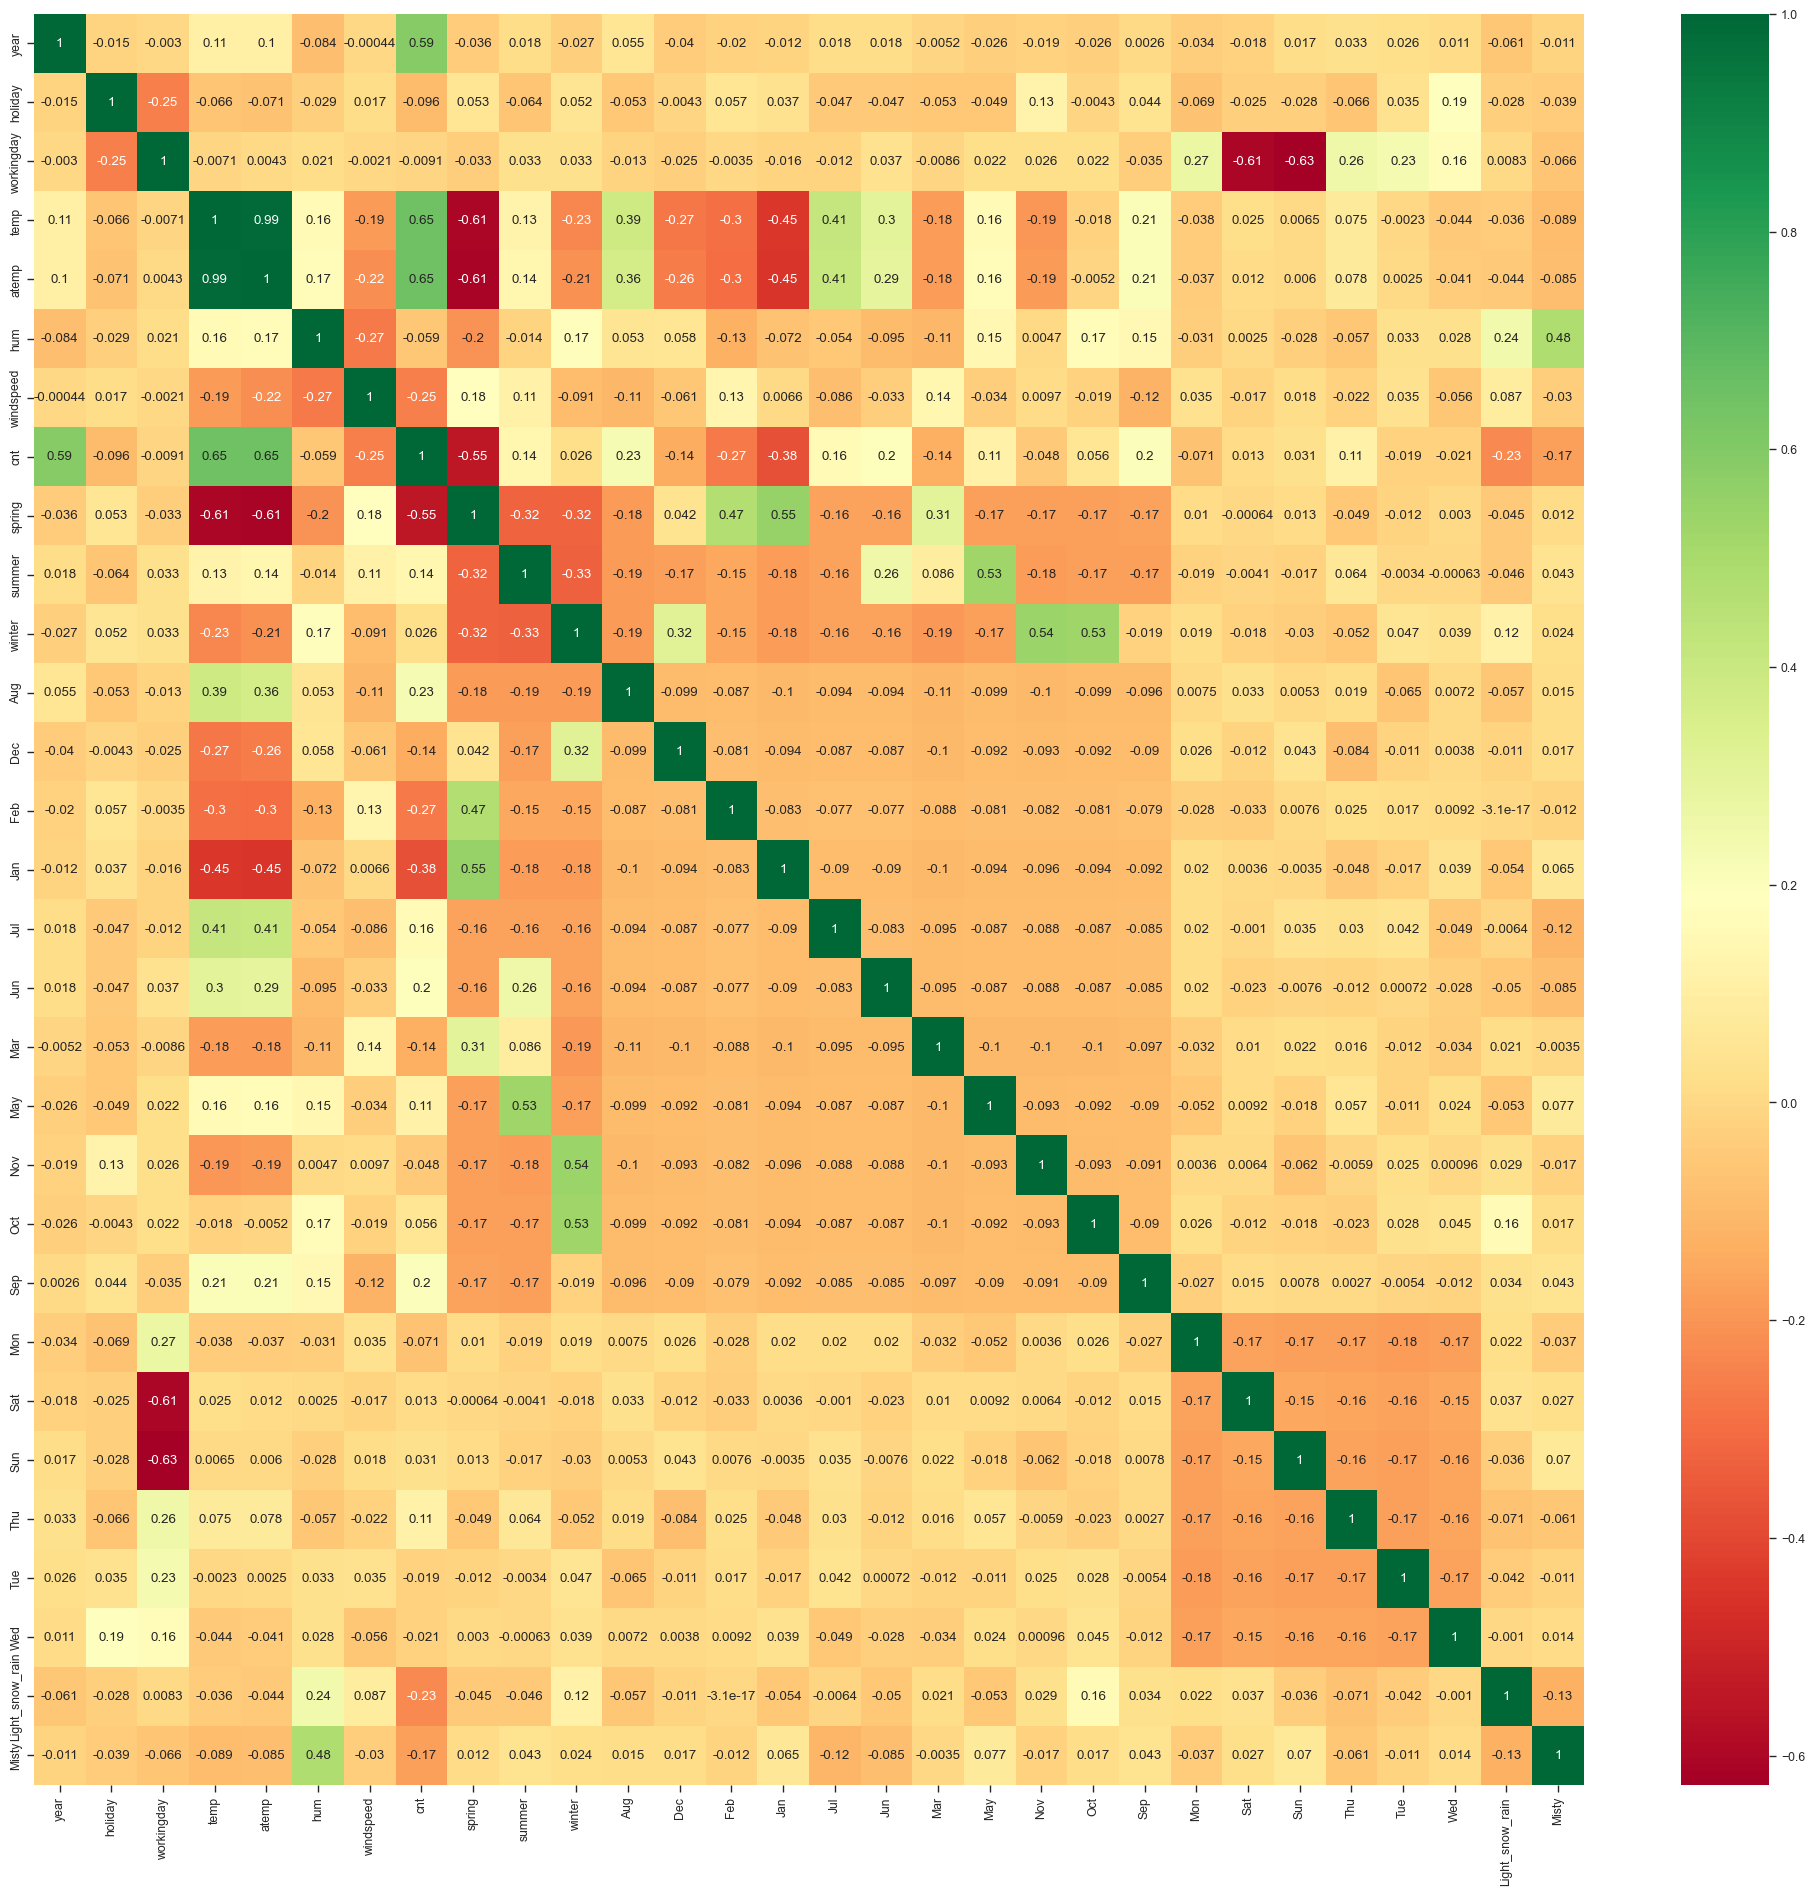

In [198]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25, 23))
sns.heatmap(df_train.corr(), annot = True, cmap="RdYlGn")
plt.show()

**We can see strong linear relationship between of temp/atemp and cnt**
 
 Visualising the relationship between of temp and cnt:

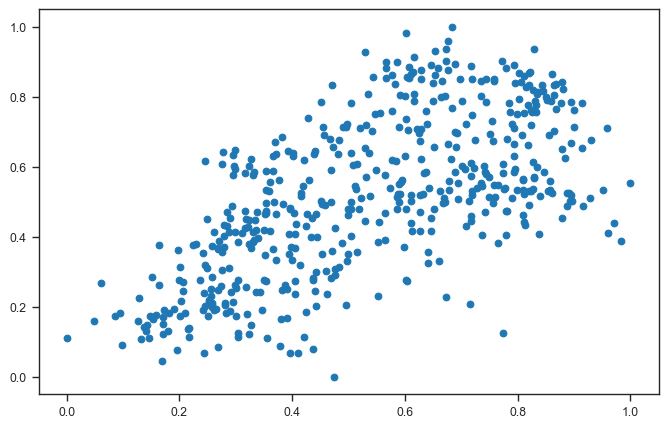

In [199]:
plt.figure(figsize=[8,5])
plt.scatter(df_train.temp, df_train.cnt)
plt.show()

This plot shows pattern of linear relationship between temp and cnt.

#### Dividing into X and Y sets for the model building

In [200]:
# cnt is the dependent variable
y_train = df_train.pop('cnt')
X_train = df_train

In [201]:
X_train.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snow_rain,Misty
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
728,1,0,1,0.245101,0.200348,0.498067,0.663106,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
111,0,0,0,0.345824,0.318819,0.751824,0.380981,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [202]:
X_train.shape

(510, 29)

### 4. Building a linear model

There are 29 independent variables. We will use RFE for choosing variables for the model

#### Using RFE

In [203]:
# Running RFE with the output number of the variable equal to 15 (about half number of variables)
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select = 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [86]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('atemp', False, 3),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Aug', False, 10),
 ('Dec', True, 1),
 ('Feb', False, 2),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 12),
 ('Mar', False, 15),
 ('May', False, 9),
 ('Nov', True, 1),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Mon', False, 8),
 ('Sat', False, 5),
 ('Sun', False, 6),
 ('Thu', False, 14),
 ('Tue', False, 7),
 ('Wed', False, 11),
 ('Light_snow_rain', True, 1),
 ('Misty', True, 1)]

In [204]:
cols = X_train.columns[rfe.support_]
cols

Index(['year', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer',
       'winter', 'Dec', 'Jan', 'Jul', 'Nov', 'Sep', 'Light_snow_rain',
       'Misty'],
      dtype='object')

#### Building model using statsmodel, for the detailed statistics

##### The first linear model: LM1

In [205]:
# Creating X_train dataframe with RFE selected variables
cols = X_train.columns[rfe.support_]
X_train_lm1 = X_train[cols]

# Running the first linear model  
lr1 = build_lm(X_train=X_train_lm1,y_train=y_train)
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          8.15e-189
Time:                        23:02:48   Log-Likelihood:                 514.19
No. Observations:                 510   AIC:                            -996.4
Df Residuals:                     494   BIC:                            -928.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3197      0.036     

In [206]:
# checking VIF
vif_calculation(X_train_lm1)

,Features,VIF
3,hum,30.89
2,temp,17.79
4,windspeed,4.72
5,spring,4.37
7,winter,4.06
6,summer,2.82
14,Misty,2.32
0,year,2.09
11,Nov,1.85
9,Jan,1.75


##### Build second model: LM2
* Drop **hum** based on its high VIF

In [207]:
# Drop hum
X_train_lm2 = X_train_lm1.drop('hum', axis=1)

# Build LM2
lr2 = build_lm(X_train=X_train_lm2,y_train=y_train)
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     184.5
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          4.75e-186
Time:                        23:02:55   Log-Likelihood:                 504.85
No. Observations:                 510   AIC:                            -979.7
Df Residuals:                     495   BIC:                            -916.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2450      0.032     

In [208]:
vif_calculation(X_train_lm2)

,Features,VIF
2,temp,5.17
3,windspeed,4.67
6,winter,2.95
4,spring,2.89
5,summer,2.24
0,year,2.07
10,Nov,1.81
8,Jan,1.66
9,Jul,1.59
13,Misty,1.57


##### Build LM3
* Although VIF of temp is > 5, we keep that variable based on general knowledge that temperature can be an important factor, and  the visualisation show that it's in linear relationship with target variable.
* We drop **Nov** based on its high P-value

In [209]:
# Drop Nov
X_train_lm3 = X_train_lm2.drop('Nov', axis=1)

# Build LM3
lr3 = build_lm(X_train=X_train_lm3,y_train=y_train)
print(lr3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.0
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          2.74e-186
Time:                        23:03:13   Log-Likelihood:                 502.67
No. Observations:                 510   AIC:                            -977.3
Df Residuals:                     496   BIC:                            -918.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2283      0.031     

In [210]:
vif_calculation(X_train_lm3)

,Features,VIF
2,temp,5.14
3,windspeed,4.62
4,spring,2.89
5,summer,2.24
0,year,2.07
6,winter,2.05
8,Jan,1.65
9,Jul,1.59
12,Misty,1.57
10,Sep,1.34


##### Build LM4
* LM3 may not good enough because VIF > 5 shows the sign of multicollinearity
* We drop **Dec** based on its high p-value, and build new model

In [211]:
# Drop Dec
X_train_lm4 = X_train_lm3.drop('Dec', axis=1)

# Build LM4
lr4 = build_lm(X_train=X_train_lm4,y_train=y_train)
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     212.3
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          8.14e-187
Time:                        23:03:30   Log-Likelihood:                 501.13
No. Observations:                 510   AIC:                            -976.3
Df Residuals:                     497   BIC:                            -921.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2154      0.030     

In [212]:
vif_calculation(X_train_lm4)

,Features,VIF
2,temp,5.13
3,windspeed,4.62
4,spring,2.75
5,summer,2.24
0,year,2.07
6,winter,1.78
7,Jan,1.61
8,Jul,1.59
11,Misty,1.56
9,Sep,1.34


##### Build LM5
* We drop **Jan** based on its high p-value, and build new model

In [213]:
# Drop Jan
X_train_lm5 = X_train_lm4.drop('Jan', axis=1)

# Build LM5
lr5 = build_lm(X_train=X_train_lm5,y_train=y_train)
print(lr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     229.6
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          5.06e-187
Time:                        23:03:37   Log-Likelihood:                 498.80
No. Observations:                 510   AIC:                            -973.6
Df Residuals:                     498   BIC:                            -922.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1994      0.030     

In [214]:
vif_calculation(X_train_lm5)

,Features,VIF
2,temp,5.09
3,windspeed,4.60
5,summer,2.23
4,spring,2.08
0,year,2.07
6,winter,1.78
7,Jul,1.58
10,Misty,1.55
8,Sep,1.34
9,Light_snow_rain,1.08


##### Build LM6
* We drop **Jul** based on its highest p-value, and build new model

In [215]:
# Drop Jul
X_train_lm6 = X_train_lm5.drop('Jul', axis=1)

# Build LM5
lr6 = build_lm(X_train=X_train_lm6,y_train=y_train)
print(lr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.4
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          1.47e-186
Time:                        23:03:47   Log-Likelihood:                 494.84
No. Observations:                 510   AIC:                            -967.7
Df Residuals:                     499   BIC:                            -921.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1909      0.030     

In [216]:
vif_calculation(X_train_lm6)

,Features,VIF
3,windspeed,4.60
2,temp,3.84
0,year,2.07
4,spring,1.99
5,summer,1.90
6,winter,1.63
9,Misty,1.55
7,Sep,1.23
8,Light_snow_rain,1.08
1,holiday,1.04


#### LM6 seem to be a good model to use because: 
* All VIFs < 5: low multicollinearity between the independent variables
* F-statistic = 248.4 and Prob (F-statistic) = 1.47e-186 (~ 0): the model is overally significant
* All p-values ~ 0: all variables are significant

We consider LM6 as our **final** model.

### 5. Residual Analysis and Assumption Validation

In [218]:
# Add a constant
X_train_final = sm.add_constant(X_train_lm6)

# Create a first fitted model
lr_final = sm.OLS(y_train, X_train_final).fit()

y_train_pred = lr_final.predict(X_train_final)
residuals = y_train - y_train_pred

#### #1 - Normality of error terms

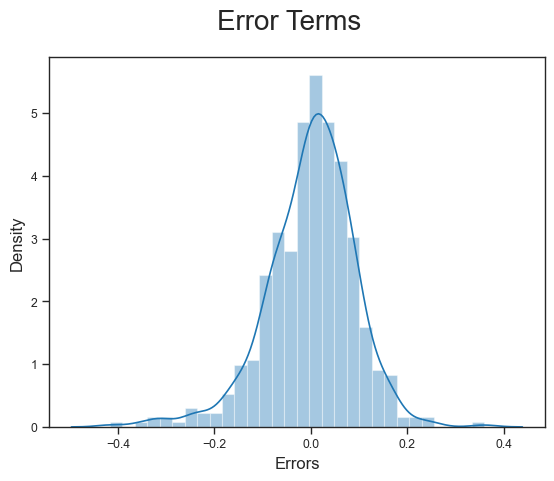

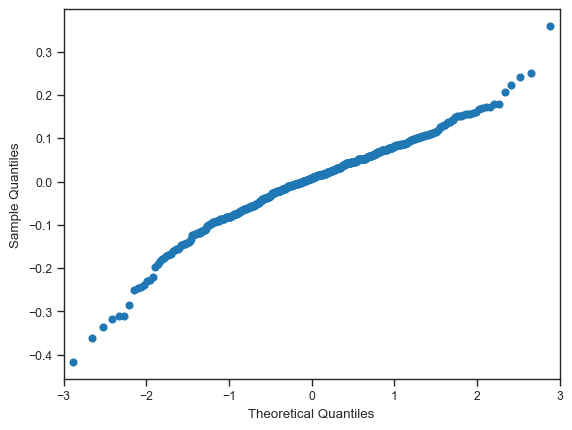

In [219]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(residuals, bins = 30)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 12)                         # X-label
plt.ylabel('Density', fontsize = 12) 
sm.qqplot(residuals)
plt.show()

* The distribution of Error Term is almost Normal Distribution with Mean = 0
* Q-Q plot show almost linear pattern

#### #2 - Multicollinearity

In [220]:
vif_calculation(X_train_lm6)

,Features,VIF
3,windspeed,4.60
2,temp,3.84
0,year,2.07
4,spring,1.99
5,summer,1.90
6,winter,1.63
9,Misty,1.55
7,Sep,1.23
8,Light_snow_rain,1.08
1,holiday,1.04


* All VIFs < 5 means **No** or **Low** multicollinearity seen.

#### #3 - Homoscedasticity

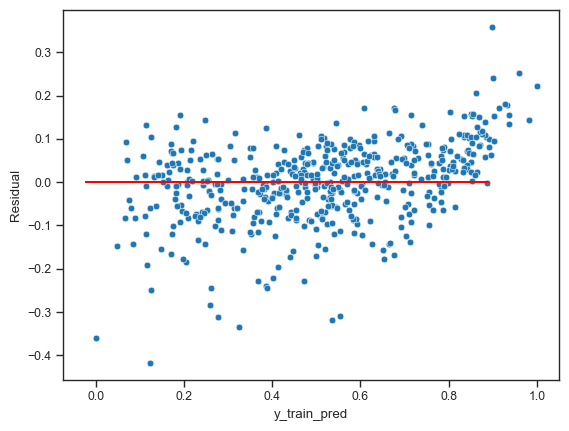

In [221]:
#y_train_pred = lr7.predict(X_train_final)
sns.scatterplot(x= y_train,y = residuals)
plt.plot(y_train_pred,(y_train - y_train), '-r')
plt.xlabel('y_train_pred')
plt.ylabel('Residual')
plt.show()

* The spread of residuals is roughly consistent across the range of predicted values.

#### #4 - No Autocorrelation of Errors

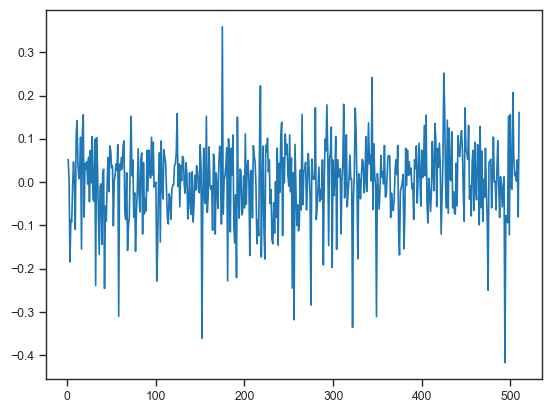

In [222]:
c = [x for x in range (1,len(residuals)+1,1)]
plt.plot(c, residuals)
plt.show()

* We don't see any visible pattern here, no autocorrelation of errors

#### #5 - Independence of Errors

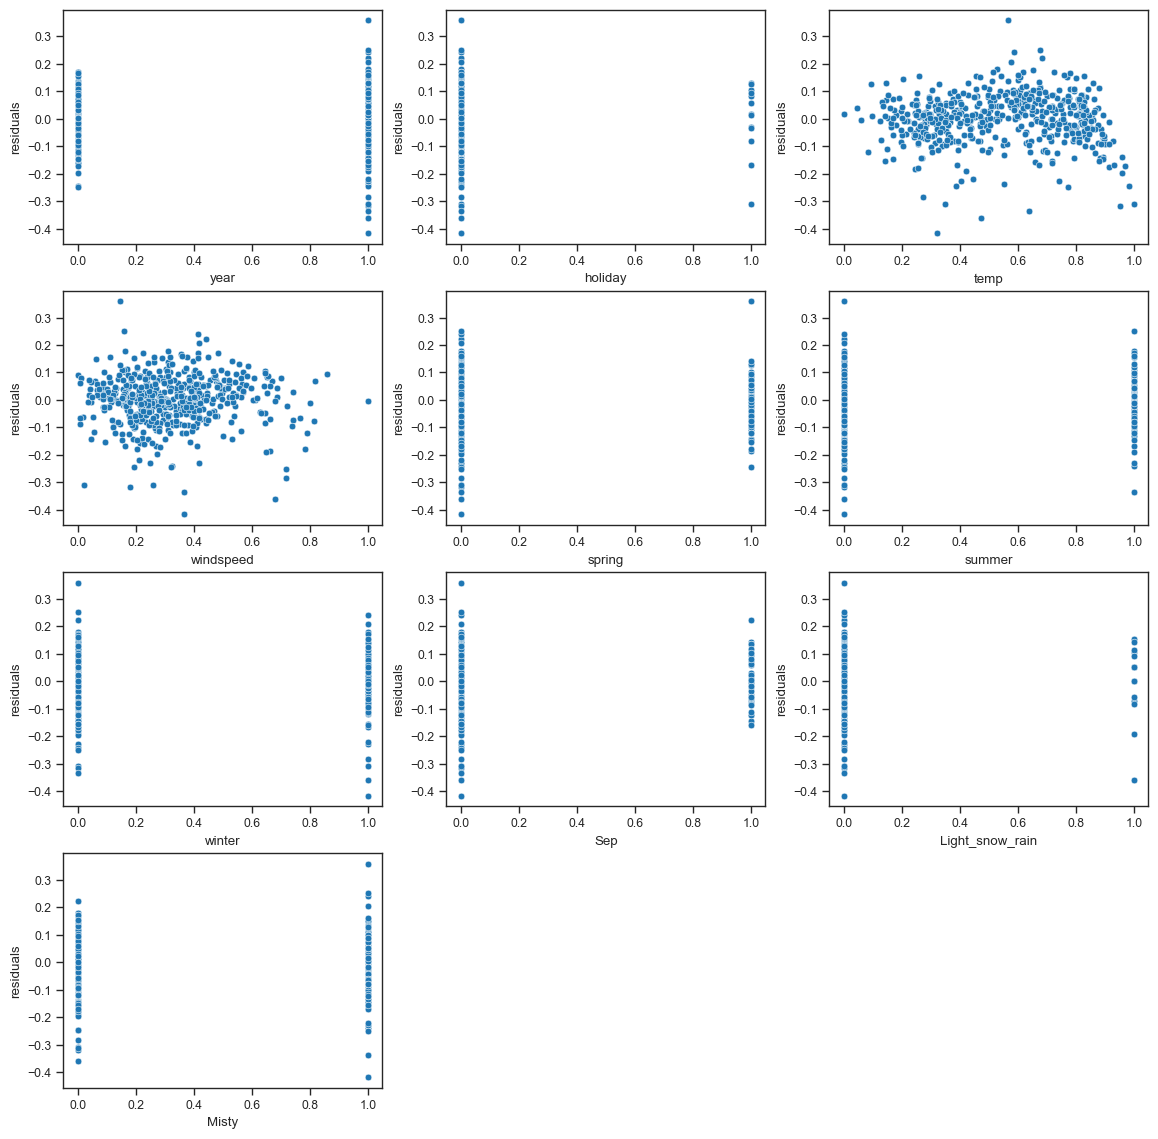

In [223]:
data = pd.DataFrame(residuals)
data.columns=['residuals']
data = pd.concat([X_train_lm6, data], axis=1)
cols = X_train_lm6.columns
vs_data(data, cols = cols, var_type='n', target= 'residuals', fig_size=(14,14))

* No visible pattern of relationship between error and independent variables has been seen, the error terms is independent.

### 6. Making Predictions Using the Final Model

#### Applying the scaling on the test sets

In [224]:
df_test.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snow_rain,Misty
184,0,1,0,29.793347,33.27085,63.7917,5.459106,6043,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
535,1,0,1,32.082500,36.04875,59.2083,7.625404,6211,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
299,0,0,0,19.270000,22.85230,81.2917,13.250121,2659,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
221,0,0,1,31.433347,34.24915,42.4167,13.417286,4780,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
152,0,0,0,29.315000,32.19710,30.5000,19.583229,4968,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [225]:
# variables for scaling
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Apply scaling
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [226]:
df_test.describe()

,year,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snow_rain,Misty
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,0.059091,0.086364,0.100000,0.077273,0.104545,0.095455,0.054545,0.086364,0.072727,0.086364,0.086364,0.118182,0.172727,0.154545,0.140909,0.122727,0.159091,0.027273,0.318182
std,0.500809,0.187620,0.480828,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,0.236333,0.281541,0.300684,0.267633,0.306665,0.294512,0.227609,0.281541,0.260281,0.281541,0.281541,0.323559,0.378873,0.362295,0.348721,0.328872,0.366595,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing into X_test and y_test

In [227]:
y_test = df_test.pop('cnt')
X_test = df_test

In [228]:
X_test_lm6 = X_test[X_train_lm6.columns]

# Adding constant variable to test dataframe
X_test_lm6 = sm.add_constant(X_test_lm6)

In [229]:
X_test_lm6.head()

,const,year,holiday,temp,windspeed,spring,summer,winter,Sep,Light_snow_rain,Misty
184,1.0,0,1,0.831783,0.084219,0,0,0,0,0,1
535,1.0,1,0,0.901354,0.153728,0,1,0,0,0,0
299,1.0,0,0,0.511964,0.334206,0,0,1,0,0,1
221,1.0,0,0,0.881625,0.339570,0,0,0,0,0,0
152,1.0,0,0,0.817246,0.537414,0,1,0,0,0,0


In [230]:
# Making predictions using the fourth model
y_pred = lr_final.predict(X_test_lm6)

### 7. Model Evaluation

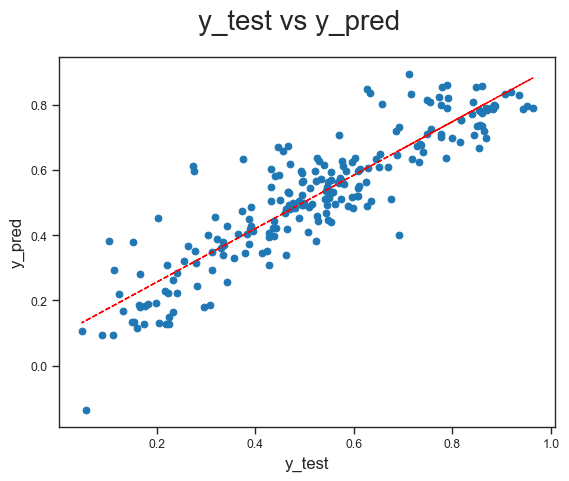

In [231]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)

z = np.polyfit(y_test, y_pred, 1)
y_hat = np.poly1d(z)(y_test)
plt.plot(y_test, y_hat, "r--", lw=1)

fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 12)                          # X-label
plt.ylabel('y_pred', fontsize = 12)      
plt.show()

**Plot shows that y_test and y_pred are strongly linear correlated**

In [232]:
r2 = r2_score(y_test, y_pred)
r2 = round(r2,3)

In [233]:
# Calculate Adjusted R-squared
# Number of rows
n = X_test_lm6.shape[0]

# Number of features (predictors, p) is the shape along axis 1
p = X_test_lm6.shape[1]

# Adjusted R-squared using the formula
adjusted_r2 = round(1-(1-r2)*(n-1)/(n-p-1),3)
print('R-squared = ' + str(r2))
print('Adjusted R-squared = ' + str(adjusted_r2))

R-squared = 0.804
Adjusted R-squared = 0.794


In [234]:
lr_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.4
Date:                Tue, 31 Oct 2023   Prob (F-statistic):          1.47e-186
Time:                        23:08:17   Log-Likelihood:                 494.84
No. Observations:                 510   AIC:                            -967.7
Df Residuals:                     499   BIC:                            -921.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1909      0.030      6.447      0.000       0.133       0.249
year                0.2341      0.008     28.237      0.000       0.218       0.250
holiday            -0.0963      0.026     -3.668      0.000      -0.148      -0.045
temp                0.4777      0.033     14.423      0.000       0.413       0.543
windspeed          -0.1481      0.025     -5.854      0.000      -0.198      -0.098
spring             -0.0554      0.021     -2.654      0.008      -0.096      -0.014
summer              0.0621      0.014      4.350      0.000       0.034       0.090
winter              0.0945      0.017      5.630      0.000       0.062       0.127
Sep                 0.0910      0.016      5.566      0.000       0.059       0.123
Light_snow_rain    -0.2850      0.025    -11.444      0.000      -0.334      -0.236
Misty              -0.0787      0.009     -8.938      0.000      -0.096      -0.061
==============================================================================
Omnibus:                       63.413   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.384
Skew:                          -0.674   Prob(JB):                     1.21e-31
Kurtosis:                       5.210   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### LM6 model on the train dataset:
* R-squared:        0.833
* Adj. R-squared: 	0.829

##### LM6 model on the test dataset:
* R-squared:        0.804
* Adj. R-squared: 	0.794

**This is a good model also for test dataset.**

### 8. Final Model Interpretation

In [235]:
print(round(lr_final.params,3))

const              0.191
year               0.234
holiday           -0.096
temp               0.478
windspeed         -0.148
spring            -0.055
summer             0.062
winter             0.094
Sep                0.091
Light_snow_rain   -0.285
Misty             -0.079
dtype: float64


We can see that the equation of our best fitted line is:

$ cnt = 0.191 + 0.234  \times  yr - 0.096  \times  holiday + 0.478 \times temp - 0.148 \times windspeed - 0.055 \times spring + 0.062 \times summer + 0.094 \times winter + 0.091 \times Sep - 0.079 \times Misty - 0.285 \times Light\_snow\_rain $

* Temperature (temp) mostly affects number of rental bikes (cnt)
* Bad weather (Misty, Light_snow_rain) and windspeed negatively affect number of rental bikes. That is reasonable as people prefer to rent a bike in clear and nice weather.
* Holiday negatively affect number of rental bikes. That makes sense because people may want to spent time for other activities in holiday.